- DATA: Machine Learning Housing Corp.! 
- TASK: to predict median house values in Californian districts, given a number of features from these districts.

In [104]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets", filter="data")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

A Quick Look at the Data Structure

In [105]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [106]:
housing.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [107]:
housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [108]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


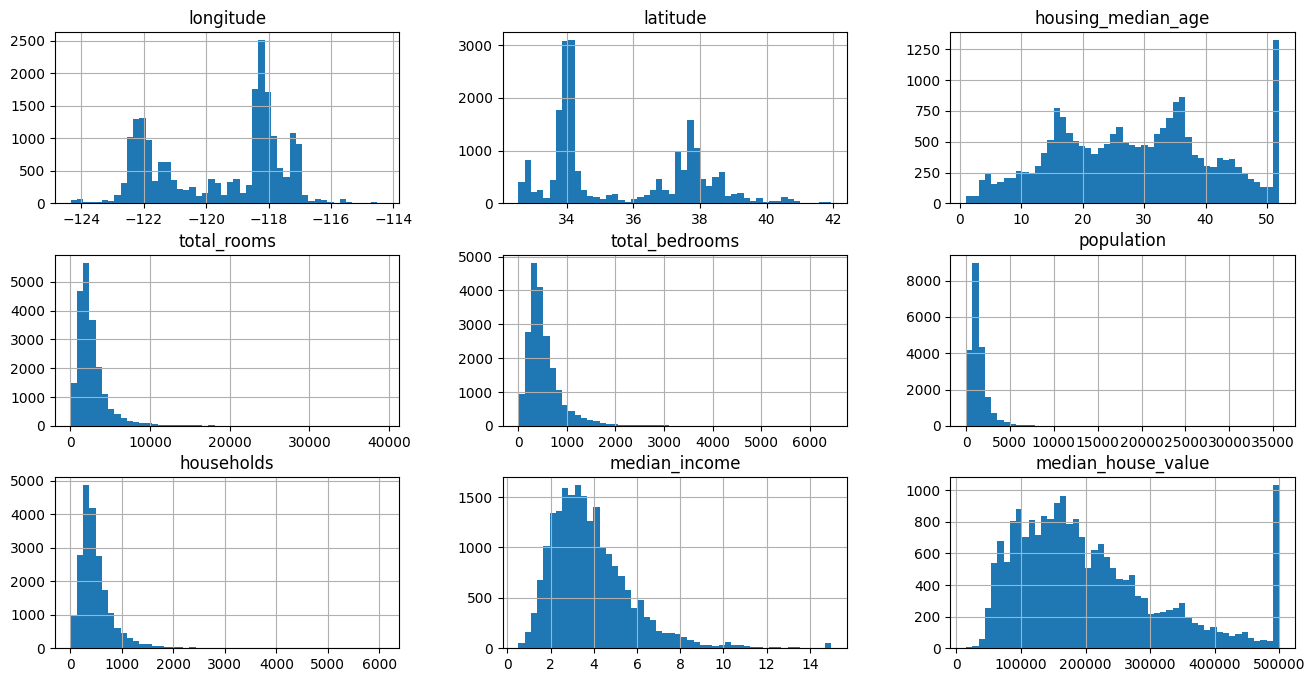

In [109]:
# another quick way to get a feel of data is to plot a histogram for each numerical attribute

import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(16,8))
plt.show()

### **Feature Distributions**

We can immediately see the **shape** of the data for each numerical feature:

* **Normal (bell-shaped)**: e.g., `median_income` may look skewed right.
* **Uniform**: evenly spread (uncommon in real-world data).
* **Skewed**: long tail on one side (common in income, house value, etc.).
* **Bimodal** or multimodal: more than one peak.

---

### **Skewness and Outliers**

* **Right-skewed** features (long tail on the right) — e.g., `median_income`, `households`.
* **Extreme outliers** — unusually high values, like in `total_rooms` or `population`.
* Features with **logarithmic or exponential-like distributions**.

---

### **Uneven Distributions**

* For features like `median_house_value`, you might notice a **sharp cutoff at 500,000** — this is due to a **data cap** in the original dataset.
* Important to handle this carefully — can **bias training** if not treated properly.

---

### Summary of Insights from Histogram Plots

| Observation                     | What It Tells You                      |
| ------------------------------- | -------------------------------------- |
| Skewed distributions            | Apply transformations (log, sqrt)      |
| Outliers                        | May need clipping or special handling  |
| Sharp cutoffs                   | Data limitations or caps               |
| Discrete spikes in numeric data | Feature may be categorical or bucketed |
| Uneven scales                   | Normalize or standardize features      |
| Missing/placeholder values      | Need data cleaning                     |


In [110]:
import numpy as np

# 1. Create income categories
housing["income_category"] = pd.cut(
    housing["median_income"],
    bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
    labels=[1, 2, 3, 4, 5]
)

# 2. Stratified sampling
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_category"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

# 3. Drop income_category (optional column)
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_category", axis=1, inplace=True)

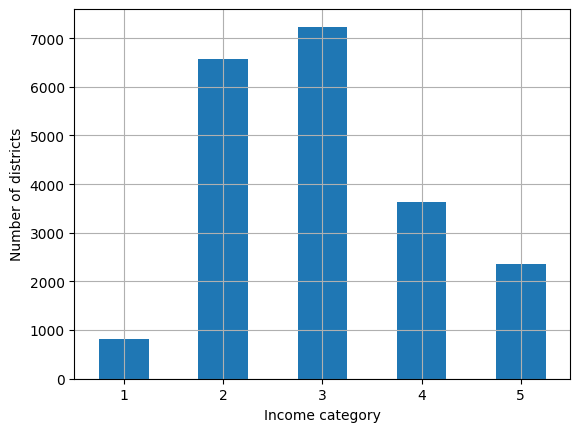

In [111]:
# income categories representation
housing['income_category'].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel('Income category')
plt.ylabel('Number of districts')
plt.show()

In [112]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'income_category'],
      dtype='object')

In [113]:
# since we're going to experiment with various transformations of the full training set, we should make a copy of the original so you can revert to it afterwards
housing = strat_train_set.copy()

## Visualization

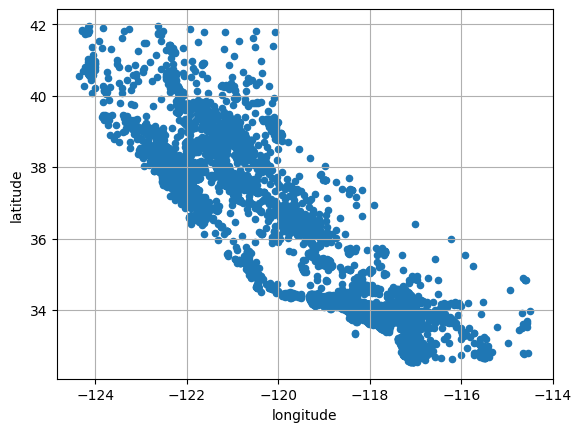

In [114]:
# because the dataset includes geographical information (latitude & longitude), it is a good idea to create a scatterplot of all the districts to visualize the data
housing.plot(kind='scatter', x='longitude', y='latitude', grid=True)
plt.show()

This looks like California all right, but other than that it is hard to see any particular pattern. <br>
Setting the alpha option to 0.2 makes it much easier to visualize the places where there is a high density of data points

<Axes: xlabel='longitude', ylabel='latitude'>

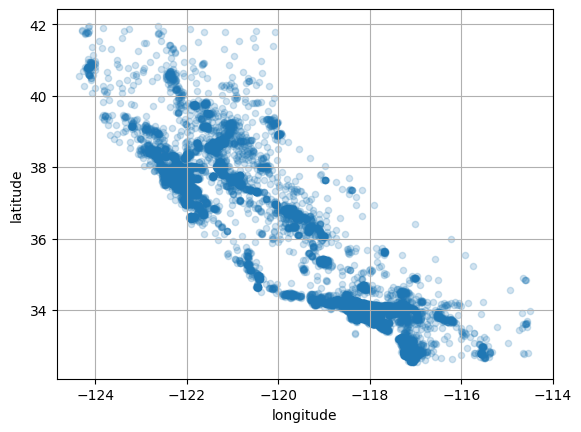

In [115]:
housing.plot(kind='scatter', x='longitude', y='latitude', grid=True, alpha=0.2)

Now we can clearly see the high-density areas, namely the Bay Area, and around Los Angeles and San Diego, plus a long line of fairly high-density areas in the Central Valley (in particular, around Sacramento and Freshno)

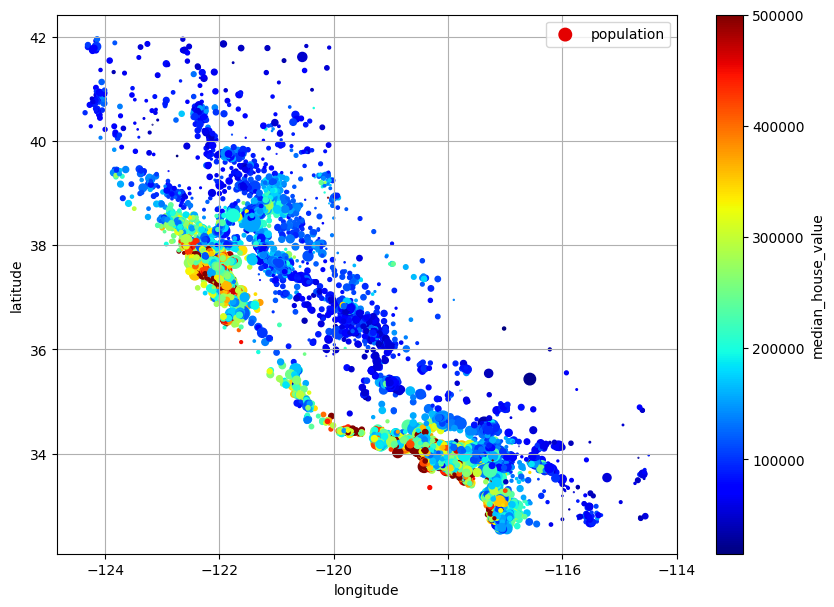

In [116]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))
plt.show()

Look at the housing prices. The radius of each circle represents the district's population (option s), and the color represents the price (option c). <br>
This image tells that the housing prices are very much related to the location (e.g., close to the ocean) and to the population density.
Here is a more beautiful version of the previous figure, with an image of California added in the background, nicer label names and no grid.

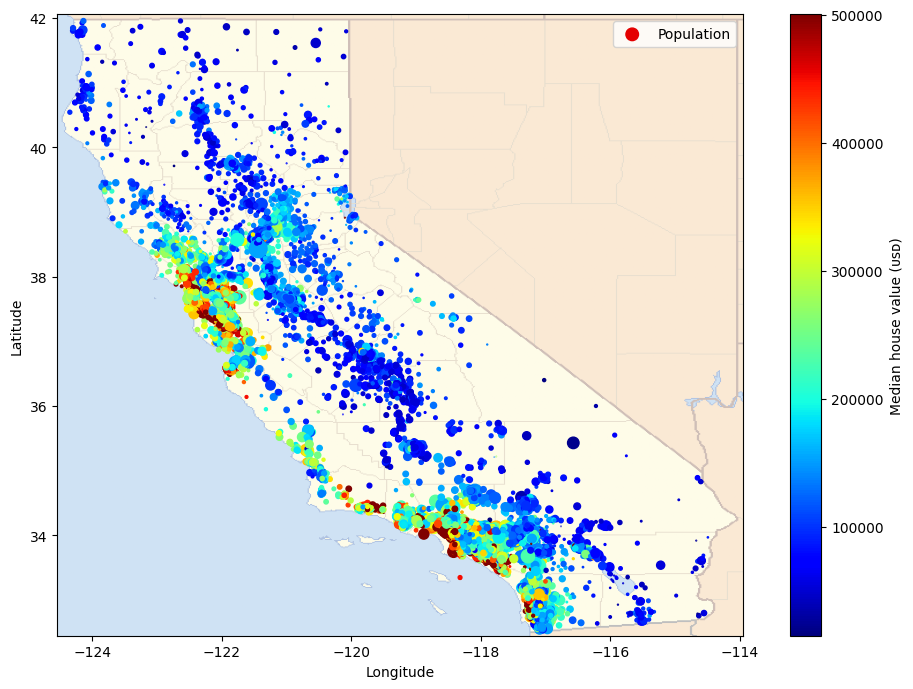

In [117]:
# Define path to the datasets and images folder
IMAGES_PATH = Path("datasets/images")
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

# Define filename and check if it exists
filename = "california.png"
file_path = IMAGES_PATH / filename

if not file_path.is_file():
    homl3_root = "https://github.com/ageron/handson-ml3/raw/main/"
    url = homl3_root + "images/end_to_end_project/" + filename
    print("Downloading", filename)
    urllib.request.urlretrieve(url, file_path)

# Rename for prettier plot
housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"
})

# Plot the housing data
housing_renamed.plot(
    kind="scatter", x="Longitude", y="Latitude",
    s=housing_renamed["Population"] / 100, label="Population",
    c="Median house value (ᴜsᴅ)", cmap="jet", colorbar=True,
    legend=True, sharex=False, figsize=(10, 7)
)

# Add California image overlay
california_img = plt.imread(file_path)
axis = -124.55, -113.95, 32.45, 42.05
plt.axis(axis)
plt.imshow(california_img, extent=axis, alpha=0.5)

# Save the figure
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

save_fig("california_housing_prices_plot")
plt.show()


## Looing For Correlations
Since the dataset is not too large, we can easily compute the _standard correlation coefficient_ (also called _Pearson's r_) between every pair of attributes using the `corr()` method:

In [118]:
corr_matrix = housing.corr(numeric_only=True)
# now we can look at how much each attribute correlates with the median house value:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

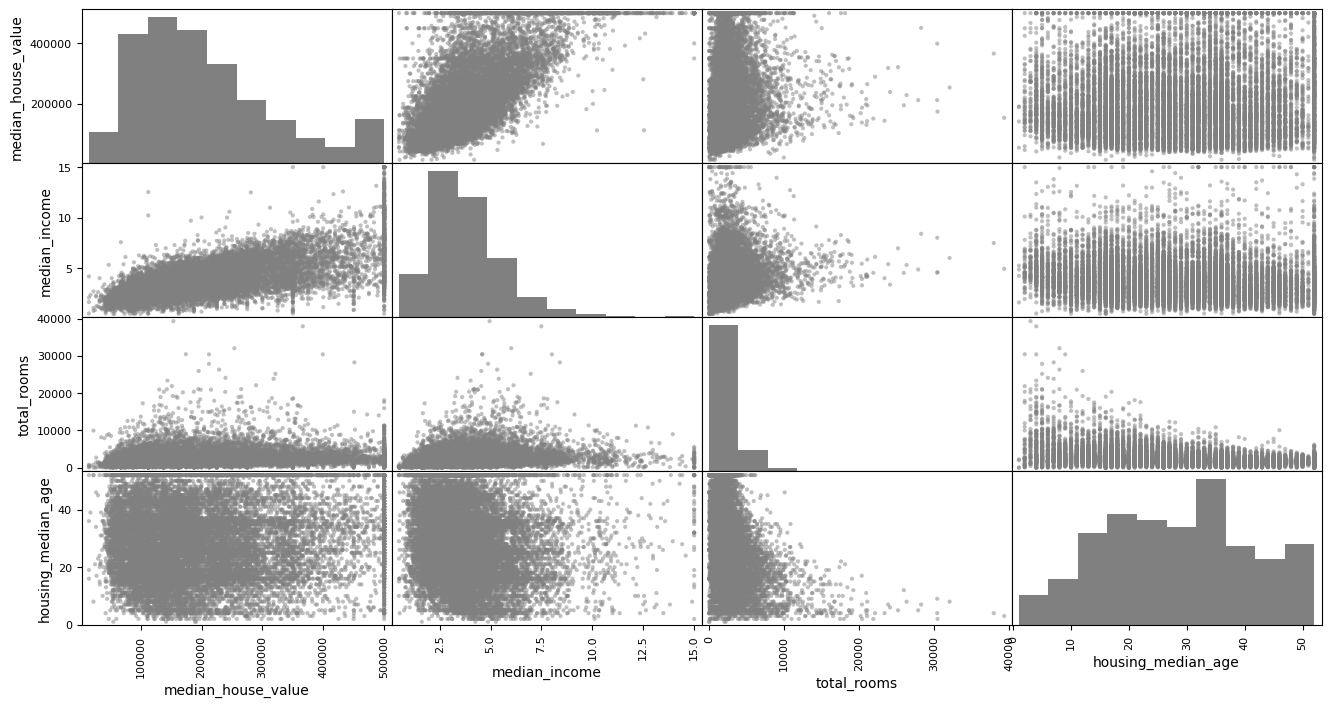

In [119]:
from pandas.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(
    housing[attributes],
    figsize=(16, 8),
    alpha=0.5,  # transparency of scatter dots
    diagonal='hist',  # show histograms on diagonal
    color='grey',  # changes scatter points
    hist_kwds={'color': 'grey'}  # histogram color
)
plt.show()

- This scatter matrix plots every numerical attribute against every other numerical attribute, plus a histogram of each numerical attribute's values on the main diagonal (top left to bottom right).
- The main diagonal would be full of straight lines if Pandas plotted each variable against inself, which would not be very useful. So instead, the Pandas displays a histogram of each attribute.
- Looking at the correlation scatterplots, it seems like the most promising attribute to predict the median house value is the median income, so we zoom in on their scatterplot:

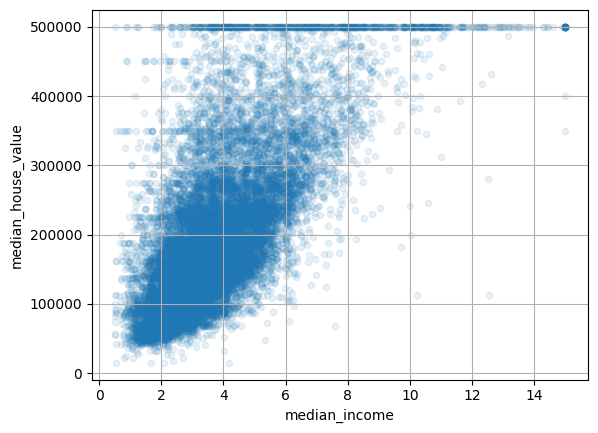

In [120]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1, grid=True)
plt.show()

This plot reveals a few things:
- First, the correlation is indeed quite strong; we can clearly see the upward trend, and the points are not too dispersed.
- Second, the price cap we noticed earlier is clearly visible as a horizontal line at $500,000.
    - But the plot also reveals other less obvious straight lines: a horizontal line around $450,000, another around $350,000, perhaps one around $280,000, and a few more below that.
- We should try to remove the corresponding districts to prevent our algorithms from learning to reproduce these data quirks.

## Experiment with Attribute Combinations
We identified a few data quirks that we want to clean up before feeding the data to a machine learning algorithm, and we found interesting correlations between attributes, in particular with the target attribute. <br>
We also noticed that some attributes have a skewed-right distribution, so we way transform them (e.g., by computing their logarithm or equare root). <br>
One last thing we have to do before preparing the data for machine learning algorithms is to try out various attribute combinations. <br>
For example: 
- The total numbers of rooms in a district is not very useful if we don't know how many households there are.
- What we really want is the number of rooms per household.
- Similarly, the total number of bedrooms by itself is not very useful: we probably want it to compare it to the number of rooms. 
- And the population per household also seems like an interesting attribute combination to look at. 
- Thus we create these new attributes as follows:

In [121]:
housing['rooms_per_house'] = housing['total_rooms'] / housing['households']
housing['bedrooms_ratio'] = housing['total_bedrooms'] / housing['total_rooms']
housing['people_per_house'] = housing['population'] / housing['households']

housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_house,bedrooms_ratio,people_per_house
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,458300.0,NEAR BAY,3.211799,0.335742,1.524178
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,483800.0,<1H OCEAN,5.504202,0.180153,1.865546
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,101700.0,INLAND,5.334975,0.200369,2.768473
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,INLAND,5.351282,0.203881,2.365385
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,361800.0,NEAR OCEAN,3.725256,0.277371,1.631399


In [122]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

Not bad! The new `bedrooms_ratio` attribute is much more correlated with the `median_house_value` than the total __number of rooms__ or __bedrooms__. <br>
Apparently houses with a lower bedroom/room ratio tend to be more expensive. <br>
The number of rooms per household is also more informative than the total number of rooms in a district --- obviously the larger the house, the more expensive they are.

> The point is to start off on the right foot and quickly gain insights that will help us get a first reasonably good prototype. <br>
> But this is an iterative process: once we get a prototype up and running, we can analyze its output to gain more insights and come back to this exploration step.

## Prepare the Data for Machine Learning Algorithms
Now it's time to prepare the data for our machine learning algorithms. Instead of doing this manually, we should write functions for this purpose, for several good reasons: 
- This will allow us to reproduce these transformations easily on any dataset (e.g., the next time we get a fresh dataset)
- We will gradually build a library of transformation functions that we can reuse in future projects.
- We can use these functions in our live system to transform the new data before feeding it to your algorithms.
- This will make it possible for us to easily try various transformations and see which combination of transformations works best.
- But first, revert to a clean training set.
- We should also separate the predictors and the labels, since we don't necessarily want to apply the same transformations to the predictors and the target values.

> Write data prep functions to make your ML pipeline scalable, reliable, and ready for production or experimentation.

In [123]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'rooms_per_house',
       'bedrooms_ratio', 'people_per_house'],
      dtype='object')

let's revert to the original training set and separate the target (note that strat_train_set.drop() creates a copy of strat_train_set without the column, it doesn't actually modify strat_train_set itself, unless we pass inplace=True)

In [124]:
# seperating them

# creates a new df that contains all columns except the 'median_house_value' column
# that means housing now holds only the predictors that our model will use as input
# in_short: we're removing the target/output column ('median_house_value') from the training data
housing = strat_train_set.drop('median_house_value', axis=1) # features only

# creates a new Series that contains only the values from the 'median_house_value' coumn
# these are the target values (labels) our model will learn to predict
# in_short: 'housing_labels' contains the house prices (the target varaible we're trying to predict)
housing_labels = strat_train_set['median_house_value'].copy()   # target variable

In [125]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

## Cleaning the Data
Most machine learning algorithms cannot work with missing features, so we will need to take care of these. For example, we noticed earlier that the total_bedrooms attribute has some missing values. We have three options to fix this: 
- get rid of the corresponding districts
- get rid of the whole attribute
- set the missing values to some value (zero, the mean, the median, etc.) This is called _imputation_.

For each option, we'll create a copy of housing and work on that copy to avoid breaking housing. We'll also show the output of each option, but filtering on the rows that originally contained a NaN value.

In [126]:
null_rows_idx = housing.isnull().any(axis=1)
housing.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,NaN,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,NaN,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,NaN,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,NaN,375.0,183.0,9.8020,<1H OCEAN


In [127]:
# option 1
housing_option1 = housing.copy()
housing_option1.dropna(subset=["total_bedrooms"], inplace=True)  
housing_option1.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [128]:
# option 2
housing_option2 = housing.copy()
housing_option2.drop('total_bedrooms', axis=1, inplace=True)
housing_option2.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,375.0,183.0,9.8020,<1H OCEAN


In [129]:
# option 3
housing_option3 = housing.copy()

median = housing["total_bedrooms"].median()
housing_option3["total_bedrooms"] = housing_option3['total_bedrooms'].fillna(median)

housing_option3.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020,<1H OCEAN


Decide to go for option 3 since it is the least destructive, but instead of the preceding code, use a handy Scikit-Learn class: _SimpleImputer_.
The benefit is that it will store the median value of each feature: this will make it possible to impute missing values not only on the training set, but also on the validation set, the test set, and any new data fed to the model.

> You want your model to see data that has been treated the same way during both training and inference. Manual methods (e.g., `df.fillna(df.median())`) don’t store these values for later use — they compute afresh each time, which can cause inconsistencies.

In [130]:
# to use it, first create a SimpleImputer instance, specifying that we want to replace each attribute's missing values with the median of that attribute

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

# since the median can only be computed on numerical attributes, we then need to create a copy of the data with only the numerical attributes
# this will exclude the text attribute ocean_proximity
housing_num = housing.select_dtypes(include=[np.number])

# now we can fit the imputer instance to the training data 
imputer.fit(housing_num)    # # This step trains the imputer

SimpleImputer(strategy='median')

The imputer has simply computed the median of each attribute and stored the result in its ___statistics____ instance variable <br>
Only the `total_bedrooms` attribute had missing values, but we can't be sure that there won't be any missing values in new data after the system goes live, so it is safer to apply the _imputer_ to all the numerical attribute

In [131]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

Now we can use this "**trained**" imputer to tansform the training set by replacing missing values with the learned medians.

In [132]:
# the imputer replaces it with the median of its respective column (calculated during .fit()).
X = imputer.transform(housing_num)

# X is a numpy array, so it has no column names or row labels
X

array([[-1.2242e+02,  3.7800e+01,  5.2000e+01, ...,  1.5760e+03,
         1.0340e+03,  2.0987e+00],
       [-1.1838e+02,  3.4140e+01,  4.0000e+01, ...,  6.6600e+02,
         3.5700e+02,  6.0876e+00],
       [-1.2198e+02,  3.8360e+01,  3.3000e+01, ...,  5.6200e+02,
         2.0300e+02,  2.4330e+00],
       ...,
       [-1.1706e+02,  3.2590e+01,  1.3000e+01, ...,  2.8140e+03,
         7.6000e+02,  4.0616e+00],
       [-1.1840e+02,  3.4060e+01,  3.7000e+01, ...,  1.7250e+03,
         8.3800e+02,  4.1455e+00],
       [-1.2241e+02,  3.7660e+01,  4.4000e+01, ...,  6.8200e+02,
         2.1200e+02,  3.2833e+00]], shape=(16512, 8))

In [133]:
imputer.feature_names_in_

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype=object)

In [134]:
# creating a df from the imputed data
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)
housing_tr.loc[null_rows_idx].head()    # NaN's have been correctly replaced with the strategy after imputation

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020


In [135]:
imputer.strategy

'median'

other ways to replace the missing data: (strategy='mean'), (strategy='most_frewuent') or with a constant value (strategy='constant', fill_value=...) <br>
The last two strategies support non-numerical data.

There are also more powerful imputers available in the __sklearn.impute__ package:
- KNNImputer replaces each missing value with the mean of the k-nearest neighbours' values for that feature. The distance is based on all the available features
- IterativeImputer trains a regression model per feature to predict the missing values based on all the other available features. It then trains the model again on the updated data, and repeats the process several times, improving the models and the replacement values at each iteration.

both for numerical features only

- We can also drop outliers here.


## Handling Text and Categorical Attributes
Now let's preprocess the categorical input feature, `ocean_proximity`:

In [136]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(8) # looking at first few instances

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


In [137]:
housing_cat.value_counts()

ocean_proximity
<1H OCEAN          7274
INLAND             5301
NEAR OCEAN         2089
NEAR BAY           1846
ISLAND                2
Name: count, dtype: int64

- There are a limited number of possible values, each of which represents a category.
- So this attribute is a categorical attribute. 
- Most ml algorithms prefer to work with numbers so convert these categories form text to numbers

In [138]:
# for that we will use Scikit-Learn OrdinalEncoder class
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

# here's what it will look now
housing_cat_encoded[:8]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

- To get list of categories: use ___categories____ instance variable
- It is a list containing a 1D array of categories for each categorical attribute

In [139]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### Problem: It implies an Order and Distance
- `OrdinalEncoder` assumes that the categories have a meaningful order and equal spacing between them.
- But many categorical features (like "ocean_proximity" in the housing dataset) are nominal, not ordinal.
- This tells the model: 
    - "NEAR OCEAN" > "INLAND"
    - and "ISLAND" is 1 unit farther from "INLAND" than "NEAR BAY"
- These relationships are __nonsense__ for this feature. The number mislead the model into learning patterns that don't exist.

### That's why we will use OneHotEncoder

In [140]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [141]:
# by default the output of a OneHotEncoder is a SciPY sparse matrix, instead of a NumPy arrays
housing_cat_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>

In [142]:
# to convert it to a (dense) NumPy array:
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], shape=(16512, 5))

Alternatively, we can set sparse=False when creating the OneHotEncoder, in which case the transform() method will return a regular (dense) NumPy array directly.

In [143]:
# to get list of categories using the encoder's categories_ instance variable
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [144]:
# pandas has a function called get_dummies(), which also converts each categorical feature into a one-hot representation, with one binary feature per category
df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})
pd.get_dummies(df_test, dtype=int)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,1,0
1,0,1


- The advantage of OneHotEncoder is that it remembers which categories it was trained on.
- This is very important because once our model is in production, it should be fed exactly the same features as during training: no more, no less.
- If we feed `get_dummies()` a df containing an unknown category, it will happily generate a column for it, but OneHotEncoder is smarter: it will detect the unknown category and raise an exception.
- If we prefer, we can set the `handle_unknown` hyperparameter to "ignore", in which case it will just represent the unknown category with zeros

> NOTE:
> - If a categorical attribute has a large number of possible categories (e.g., country code, profession, species), then one-hot encoding will result in a large number of input features.
> - This may slow down training and degrade performance. If this happens, we should replace the categorical input with useful numerical features related to the categories input with useful numerical features related to the categories:
> - for example, we could replace the ocean_proximity feature with the distance to the ocean, a country code could be replaced by it's population and GDP per capita.

> Alternatively, we can use one of the encoders provided by the category_encoders package on github.

> Or, when dealing with neural networks, we can replace each category with a learnable, low-dimensional vector called an embedding. This is an example of representation learning.


- When we fit any Scikit-Learn estimator using a DataFrame, the estimator stores the column names in the feature_names_in_ attribute.
- Scikit-Learn then ensures that any dataframe fed to this estimator after that the same column names.
- Transforms also provide a get_feature_names_out() method that we can use to build a DataFrame around the transform's output

In [145]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [146]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

## Feature Scaling and Transformation
- One of the most important transformations we need to apply to our data is ___feature scaling___.
- With few exceptions, ml algorithms don't perform well when the input numerical attributes have very different have very different scales.
- This is the case for the housing data: the total number of rooms ranges from about 6 to 39320, while the median incomes only range from 0 to 15.
- Without any scaling, most models will be biased toward ignoring the median income and focusing more on the number of rooms.
- > There are two common ways to get all attributes to have the same scale: ___min-max scaling___ and ___standardization___

In [147]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

In [148]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

To scale a sparse matrix without converting it to a dense matrix first, use a StandardScaler with its _with_mean_ hyperparameter set to _False_

- When a feature's distribution has a heavy tail (i.e., when values far from the mean are not exponentially rare), both min-max scaling and standardization will squash most values into a small range.
- ML models generally don't like this at all. So before we scale the feature, we should first transform it to shrink the heavy tail, and if possible to make the distribution roughly symmetrical.
- If the feature has a really long and heavy tail, such as a power law distribution, then replacing the feature with its logarithm may help.

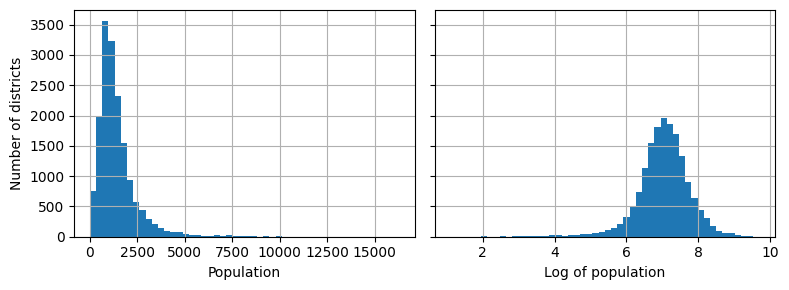

In [149]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
housing["population"].hist(ax=axs[0], bins=50)
housing["population"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")
save_fig("long_tail_plot")
plt.show()

# This shows how much better this feature looks when we compute its log: it's very close to a Gaussian distribution (i.e., bell-shaped)

Another approach to handle heavy-tailed features consists in _bucketizing_ the feature
---

###  **Bucketizing a Feature (for Heavy-Tailed Distributions)**

* **Definition**: Divides a feature’s distribution into roughly equal-sized buckets (bins).
* **How It Works**: Replace each value with the index of the bucket it belongs to (like `income_cat` used for stratified sampling).
* **Purpose**: Makes distribution more uniform → easier for ML algorithms to handle.
* **Scaling**: After bucketizing, further scaling may not be needed. You can:

  * Use percentiles (produces uniform distribution).
  * Normalize by dividing by the number of buckets (brings values into \[0,1] range).

---

###  **Bucketizing for Multimodal Distributions**

* **When to Use**: Feature has multiple peaks (modes), e.g., `housing_median_age`.
* **Approach**:

  * Bucketize, but treat bucket IDs as categorical values (not numeric).
  * Use **OneHotEncoder** to encode these categorical bucket indices.
* **Why**: Helps models learn distinct patterns for different ranges.

  * Example: Homes built 35 years ago may have unique traits affecting price.

---

###  **Radial Basis Function (RBF) Transformation**

* **Goal**: Transform multimodal features by measuring similarity to specific modes.
* **How**:

  * Add a new feature that represents similarity to each mode.
  * Use **RBF** (Radial Basis Function) for similarity.
* **Gaussian RBF Formula**:

  $
  \text{similarity}(x, 35) = \exp(-\gamma(x - 35)^2)
  $

* **γ (gamma)**: Controls how fast the similarity decreases as $x$ moves away from 35.
* **In Scikit-Learn**: Use `rbf_kernel()` to apply this transformation.



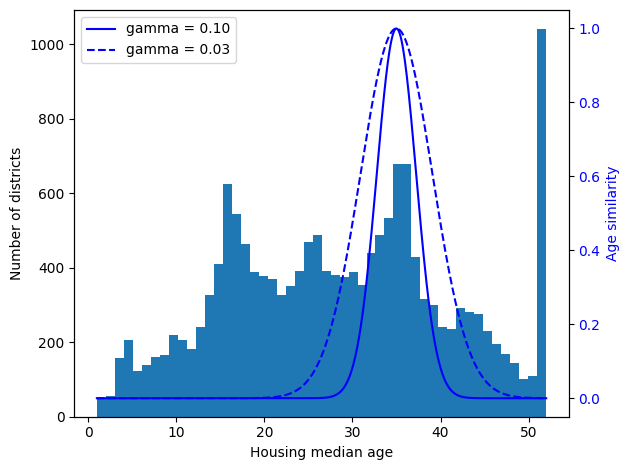

In [150]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)

ages = np.linspace(housing["housing_median_age"].min(),
                   housing["housing_median_age"].max(),
                   500).reshape(-1, 1)
gamma1 = 0.1
gamma2 = 0.03
rbf1 = rbf_kernel(ages, [[35]], gamma=gamma1)
rbf2 = rbf_kernel(ages, [[35]], gamma=gamma2)

fig, ax1 = plt.subplots()

ax1.set_xlabel("Housing median age")
ax1.set_ylabel("Number of districts")
ax1.hist(housing["housing_median_age"], bins=50)

ax2 = ax1.twinx()  # create a twin axis that shares the same x-axis
color = "blue"
ax2.plot(ages, rbf1, color=color, label="gamma = 0.10")
ax2.plot(ages, rbf2, color=color, label="gamma = 0.03", linestyle="--")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel("Age similarity", color=color)

plt.legend(loc="upper left")
save_fig("age_similarity_plot")
plt.show()

# Gaussian RBF feature measuring the similarity between the housing meadian age and 35

- So far we've only looked at the input features, but the target values may also need to be transformed.
- For example, if the target distribution has a heavy tail, we may choose to replace the target with its logarithm.
- But if we do, the regression model will now predict the log of the median house value, not the median house value irself.
- We will need to compute the exponential of the model's prediction if we want the predicted median house value.
- Luckily, most of the Scikit-Learn's transformers have an __inverse_transform()__ method, making it easy to compute the inverse of their transformations.

In [151]:
# This code shows how to scale the labels using a StandardSaler, 
# then train a simple linear regression model on the resulting scaled labels and
# use it to make predictions on some new data, 
# which we transform back to the original scale using the trained scaler's inverse_transform() method.

# NOTE that we convert the labels from a Pandas Series to a DataFrame, since the StandardScaler expects 2D inputs.
# Also, in this example we just train the model on a single raw input feature (median income), for simplicity:

from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())  # StandardScaler requires a 2D array, so to_frame()

model = LinearRegression()
model.fit(housing[['median_income']], scaled_labels)
some_new_data = housing[['median_income']].iloc[:5]     # pretend this is new data

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)   # convert predictions back to original

- This works fine, but a simpler option is to use a TransformedTargetRegressor.
- We just need to construct it, giving it the regression model and the label transformer, then fit it on the training set, using the original unscaled labels.
- It will automatically use the transformer to scale the labels and train the regression model on the resulting scaled labels, just like we did previously.
- Then, we want to make a prediction, it will call the regression model's predict() method and use the scaler's inverse_transformer() method to produce the pridiction


###  **What is `TransformedTargetRegressor`?**

It's a **wrapper around a regressor** that:

* Automatically **transforms the target (labels)** during training.
* Automatically **inverts the transformation** during prediction.


###  **Benefits**

* **Less code**.
* **Cleaner pipelines**.
* **No need to remember to inverse-transform predictions manually**.
* Supports **any transformer** (e.g., `StandardScaler`, `FunctionTransformer` for log transforms).


###  **How It Works Behind the Scenes**

1. You provide:

   * A **regressor** (like `LinearRegression()`).
   * A **transformer** (like `StandardScaler()`).

2. When you call `.fit(X, y)`:

   * `y` is transformed using `transformer.fit_transform(y)`.
   * Model is trained on `X` and **transformed `y`**.

3. When you call `.predict(X)`:

   * Model predicts **transformed `y_pred`**.
   * `TransformedTargetRegressor` automatically applies `inverse_transform()` to return **original-scale predictions**.


In [152]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(), transformer=StandardScaler())
model.fit(housing[['median_income']], housing_labels)
predictions = model.predict(some_new_data)

## Custom Transformers
- Although Scikit-Learn provides many useful transformers, we will need to write our own for tasks such as custom transformations, cleanup operations, or combining specific attributes
- For transformations that don't require any training, we can just write a function that takes a NumPy array as input and outputs the transformed array.
#
- For example: it's often a good idea to transform features with heavy-tailed distributions by replacing them with their logarithm (assuming the feature is positive and the tail is on the right)
- Let's create a log-transformer and apply it to the _population_ feature:

In [153]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)  # inverse_func is optional
log_pop = log_transformer.transform(housing[['population']])

Our transformation function can take hyperparameters as additional arguments. <br>
For example, here's how to create a transformer that computes the same Gaussian RBF similarity measure as earlier:

In [154]:
rbf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[35.]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[['housing_median_age']])

# Note that there's no inverse function for the RBF kernel, since there are always two values at a given distance from a fixed point.
# Also note that rbf_kernel() does not treat the features separately.

If we pass it an array with two features, it will measure the 2D distance (Euclidean) to measure similarity. <br>
For example: here's how to add a feauture that will measure the geographic similarity between each district and San Fransisco:

In [155]:
sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = sf_transformer.transform(housing[["latitude", "longitude"]])

Custom transformers are also useful to combine features. <br>
For example: here's a FunctionTransformer that computes the ratio between the input features 0 and 1:

In [156]:
ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])
ratio_transformer.transform(np.array([[1., 2.], [3., 4.]]))

array([[0.5 ],
       [0.75]])

- FunctionTransformer is very handy, but what if you would like your transformer to be trainable, learning some parameters in the fit() method and using them later in the transform() method?
- For this, we need to write a custom class.
- Scikit-Learn relies on duck typing, so this calss does not have to inherit from any particular base class.
- All it needs is three methods: 
    - fit() (which must return self)
    - transform()
    - fit_transform()

#
Here's a custom transformer that acts much like the StandardScaler:

In [157]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):  # no *args or **kwargs!
        self.with_mean = with_mean

    def fit(self, X, y=None):  # y is required even though we don't use it
        X = check_array(X)  # checks that X is an array with finite float values
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]  # every estimator stores this in fit()
        return self  # always return self!

    def transform(self, X):
        check_is_fitted(self)  # looks for learned attributes (with trailing _)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_

### Few things to note:
- The `sklearn.utils.validation` package contains several functions we can use to validate the inputs. Production code should have them.
- Scikit-Learn pipelines require the `fit()` method to have two arguments `X` and `y`, which is why we need the `y=None` argument even though we don't use `y`.
- All Scikit-Learn estimators set `n_features_in_` in the `fit()` method, and they ensure that the data passed to `transform()` or `predict()` has this number of features.
- The `fit()` method must return self.
- The implementation is not 100% complete: all estimators should set `features_names_in` in the `fit()` method when they are passed a DataFrame. Moreover, all transformers should provide a `get_feature_names_out()` method, as well as an `inverse_transform()` method when their transformation can be reversed.

A custom transformer can (and often does) use other estimators in its implementation.
#
For example, the following code demonstrates custom transformer that uses a `KMeans` clustered in the `fit()` method to identify the main clusters in the training data, and then uses `rbf_kernel()` in the` transform()` method to measure how similar each sample is to create cluster centre:

In [158]:
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, n_init=10,
                              random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]
    
# We can check whether our custom estimator respects Scikit-Leanr's API by passing an instance to check_estimator() from the sklearn.utils.estimator_checks package

- Later we will see that, `k-means` in a clustering algorithm that locates clusters in the data.
- How many it searches for is controlled by the `n_clusters` hyperparameter.
- After training, the cluster centers are available via the `cluster_centers_` attribute.
- The `fit()` method of KMeans supports an optional argument `sample_weight`, which lets the user specify the relative weights of the samples.
- `k-means` is a stochastic algorithm, meaning that it relies on randomness to locate the clusters, so if you want reproducible results, you must set the `random_state` parameter.
- As we can see, despite the complexity of the tasks, the code is fairly straightforward.
- Now let's use this custom transformer

In [159]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(housing[['latitude', 'longitude']], sample_weight=housing_labels)

- This code creates a `ClusterSimilarity` transformer, setting the number of clusters to 10.
- Then it calls `fit_transform()` with the latitude and longitude of every district in the training set, weighting each district by its median house value.
- The transformer uses `k-means` to locate the clusters, then measures the Gaussian RBF similarity between each district and all 10 cluster centers.
- The result is a matrix with one row per district, and one column per cluster.
- Let's look at the first three rows, rounding to two decimal places:

In [160]:
similarities[:3].round(2)

array([[0.08, 0.  , 0.6 , 0.  , 0.  , 0.99, 0.  , 0.  , 0.  , 0.14],
       [0.  , 0.99, 0.  , 0.04, 0.  , 0.  , 0.11, 0.  , 0.63, 0.  ],
       [0.44, 0.  , 0.3 , 0.  , 0.  , 0.7 , 0.  , 0.01, 0.  , 0.29]])

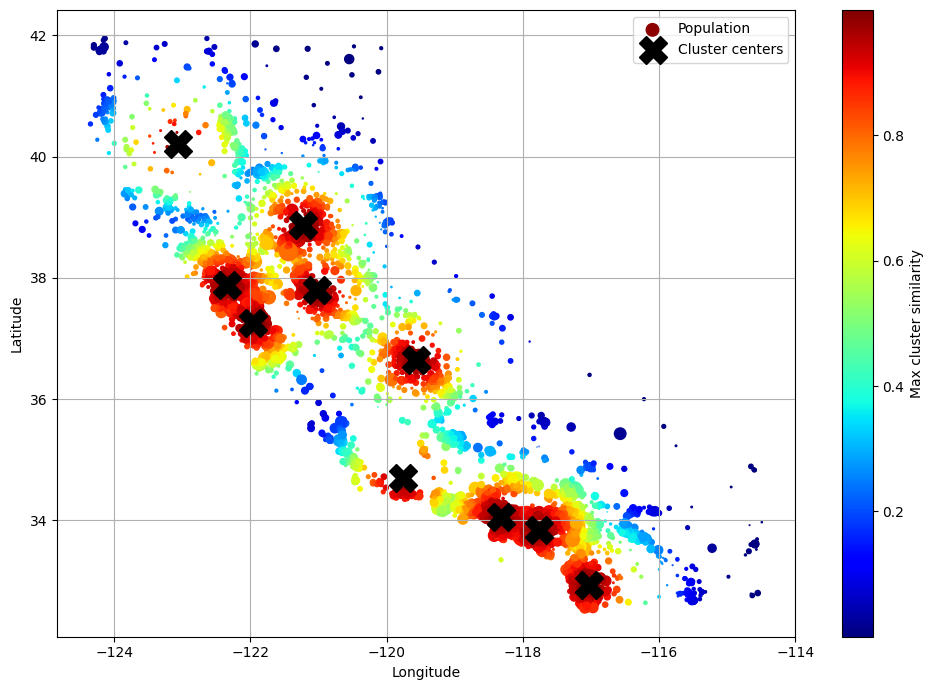

In [161]:
housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
plt.legend(loc="upper right")
save_fig("district_cluster_plot")
plt.show()  # Gaussian RBF similarity to the nearest cluster center

# This figure shows the 10 clusters centers found by k-means. The district are colored according to their geographic similarity to their closest cluster center. 
# As we can see, most clusters are located in highly populated and expensive areas.

## Transformation Pipelines
- As we can see, there are many data transformation steps that need to be executed in the right order.
- Fortunately, Scikit-Learn provides the Pipeline class to help with such sequences of transformations.
- Here is a small pipeline for numerical attributes, which will first impute then scale the input features:

In [162]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('stadardize', StandardScaler()),
])

- The __Pipeline__ constructor takes a list of name/estimator pairs (2-tuples) defining a sequence of steps.
- The names can be anything you like, as long as they are unique and don't contain double underscores (__).
- They will be useful later, when we discuss hyperparameter tuning.
- The estimators must all be transformers (i.e., they must have a `fit_transform()` method), except for the last one, which can be anything: a transformer, a predictor, or any other type of estimator.

> In Jupyter notebook, if we import `sklearn` and run `sklearn.set_config(display='diagram')`, all Scikit-Learn estimators will be rendered as interactive diagrams. This is particularly useful for visualizing pipelines.

In [163]:
num_pipeline

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('stadardize', StandardScaler())])

If we don't want to name the transformers, we can use the `make_pipeline()` function instead; it takes transformers as positional arguments and creates a Pipeline using the names of the transformers' classes in lowercase and without underscores

In [164]:
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())

If multiple transformers have the same name, an index is appended to their names.

- When we call the pipeline's `fit()` method, it calls `fit_transform()` sequentially on all the transformers, passing the output of each call as the parameter to the next call until it reaches the final estimator, for which it just calls the `fit()` method.
- The pipeline exposes the same methods as the final estimator.
- In this example, the last estimator is a __StandardScaler__, which is a transformer, so the pipeline also acts like a transformer.
- If we call the pipeline's `transform()` method, it will sequentially apply all the transformations to the data.
- If the last estimator were a predictor instead of a transformer, then the pipeline would have a `predict()` method rather than a `transform()` method.
- Calling it would sequentially apply all the transformations to the data and pass the results to the predictor's `predict()` method.
- Let's call the pipeline's `fit_transform()` method and look at the output's first two rows, rounded to two decimal places:

In [165]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

In [166]:
# to recover a nice dataframe, use the pipeline's get_feature_names_out() method:
df_housing_num_prepared = pd.DataFrame(housing_num_prepared, columns=num_pipeline.get_feature_names_out(), index=housing_num.index)

- Pipelines support indexing; for example,
    - pipeline[1] returns the second estimator in the pipeline, 
    - pipeline[:-1] returns a Pipeline object containing all but the last estimator.
- We can also access the estimators via the _steps_ attribute, which is a list of name/estimator pairs, or via the named_steps dictionary attribute, which maps the names to the estimators.
- For example, 
    - `num_pipeline['simpleimputer']` returns the estimator named '___simpleimputer___'

- So far, we have handled the categorical columns and the numerical columns separately. It would be more convenient to have a single transformer capable of handling all columns, applying the appropriate transformations to each column.
- For this, we can use a `ColumnTransformer`

In [167]:
# the following ColumnTransformer will apply num_pipeline to the numerical attributes and cat_pipeline to the categorical attribute:

from sklearn.compose import ColumnTransformer

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

- Since listing all the column names is not very convenient, Scikit-Learn provides a `make_column_selector()` function that returns a selector function we can use to automatically select all the features of a given type, such as numerical or categorical.
- We can pass this selector function to the `ColumnTransformer` instead of column names or indices.
- Moreover, if we don't care about naming the transformers, we can use `make_column_transformer()` which chooses the names for us, just like `make_pipelines()` does.
- For example, the following code creates the same `ColumnTransformer` as earlier, except the transformers are automatically named "__pipeline-1__" and "__pipeline-2__" instead of "__num__" and "__cat__":

In [168]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

Now we are ready to apply this __ColumnTransformer__ to the housing data:

In [169]:
housing_prepared = preprocessing.fit_transform(housing)

'''
Now we have a preprocessing pipeline that takes the entire training dataset and applies each transformer to the appropiate columns,
then concatenates the transformed columns horizontally (transformers must never change the number of rows)
Once again this returns a NumPy array, but we can get the column names using preprocessing.get_feature_names_out() and wrap the data in a nice DataFrame as we did before.
'''

'\nNow we have a preprocessing pipeline that takes the entire training dataset and applies each transformer to the appropiate columns,\nthen concatenates the transformed columns horizontally (transformers must never change the number of rows)\nOnce again this returns a NumPy array, but we can get the column names using preprocessing.get_feature_names_out() and wrap the data in a nice DataFrame as we did before.\n'

- The `OneHotEncoder` returns a sparse matrix and the `num_pipeline` returns a dense matrix. 
- When there is such a mix of sparse and dense matrices, the ColumnTransformer estimates the density of the final matrix (i.e., the ratio of nonzero cells), and it returns a sparse matrix if the density is lower than a given threshold (by default, `sparse_threshold=0.3`). 
- In this example, it returns a dense matrix.

- We are almost ready to train some models!
- Now we want to create a sinle pipeline that will perform all the transformations we have experimented with up to now.
- Let's recap what the pipeline will do and why:

- Missing values in numerial features will be imputed by replacing them with the median, as most ML algorithms don't expect missing values. In categorical features, missing values will be replaced by the most frequent category.
- The categorical feature will be one-hot encoded, as most ML algorithms only accept numerical inputs.
- A few ratio features will be computed and added: bedrooms_ratio, rooms_per_house, and people_per_house. Hopefully these will better correlate with the median house value, and thereby help the ML models.
- A few cluster similarity features will also be added. These will likely be more useful to the model than latitude and longitude.
- Features with a long tail will be replaced by their logarithm, as most models prefer features with roughly uniform of Gaussian distributions.
- All numerical features will be standardized, as most ML algorithms, as most ML algorithms prefer when all features have roughly the same scale.

In [170]:
# the code that builds the pipeline to do all of this 

def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())
preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)  # one column remaining: housing_median_age

In [171]:
# Running this ColumnTransformer, it performs all the transformations and outputs a NumPy array with 24 features:

housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(16512, 24)

In [172]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

# Select and Train a Model
We got the data and explored it, we sampled a training set and a test set, and you wrote a preprocessing pipeline to automatically clean up and prepare our data for machine learning algorithms. We are now ready to select and train a machine learning model.
## Train and Evaluate on the Training Set
Things are going to be easy! We decide to train a very basic linear regression model to get started:

In [173]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

# now we have a working linear regression model.

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002C500197C50>)])),
                ('linearregression', LinearRegression())])

In [174]:
# trying on the training set, looking at the first five predictions and comparing them to the labels

housing_predictions = lin_reg.predict(housing)
housing_predictions[:5].round(-2) # -2 = round to the nearest hundred

array([242800., 375900., 127500.,  99400., 324600.])

In [175]:
housing_labels.iloc[:5].values

array([458300., 483800., 101700.,  96100., 361800.])

In [176]:
# compute the error ratios discussed in the book
error_ratios = housing_predictions[:5].round(-2) / housing_labels.iloc[:5].values - 1
print(", ".join([f"{100 * ratio:.1f}%" for ratio in error_ratios]))

-47.0%, -22.3%, 25.4%, 3.4%, -10.3%


- Well, it works, but not always:
    - the first prediction is way off (by over $200,000!), while the other predictions are better:
    - two are off about by 25%, and two are off by less than 10%.
- Remember that we choose to use the RMSE as our performance measure, so we want to measure this regression model's RMSE on the whole training set using Scikit-Learn's mean_squared_error() function, with the squared argument set to False.

In [177]:
from sklearn.metrics import mean_squared_error

try:
    from sklearn.metrics import root_mean_squared_error
except ImportError:
    from sklearn.metrics import mean_squared_error

    def root_mean_squared_error(labels, predictions):
        return mean_squared_error(labels, predictions, squared=False)

lin_rmse = root_mean_squared_error(housing_labels, housing_predictions)
lin_rmse

68647.95686706626

- This is better than nothing, but clearly not a great score: the `median_housing_values` of most districts range between $120,000 and $265,000, so a typical prediction error of $68,628 is really not very satisfying.
- This is an example of a model underfitting the training data.
- When this happens it can mean that the features do not provide enough information to make good predicitions, or that the model is not powerful enough.
- The main ways to fix underfitting are to select a more powerful model, to feed the training algorithm with better features, or to reduce the constraints on the model.
- This model is not regularized, which rules out the last option.
- We could try to add more features, but first we want to try a more complex model to see how it does.
- We decide to try a DecisionTreeRegressor, as this is a fairly powerful model capable of finding complex nonlinear relationships in the data.

In [178]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002C500197C50>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [179]:
housing_predictions = tree_reg.predict(housing)
tree_rmse = root_mean_squared_error(housing_labels, housing_predictions)
tree_rmse

# No error at all? Could this model really be absolutely perfect? Of course, it is much more likely that the model has badly overfit the data. How can we be sure?
# As we say earlier, we don't want to touch the test set until we are ready to launch a model we are confident about, so we need to use part of the training set for training and part of it for model validation.

0.0

## Better Evaluation Using Cross-Validation
- One way to evaluate the dicision tree model would be to use the train_test_split() function to split the training set into a smaller training set and a validation set, then train our models against the smaller training set and evaluate them against the validation set.
- It's a bit of effort, but nothing too dificult, and it would work fairly well.
- A great alternative is to use Scikit-Learn's k_-fold cross-validation feature.
- The following code randomly splits the training set into 10 nonoverlapping subsets called folds, then it trains and evaluates the decision tree model 10 times, picking a different fold for evaluation every time and using the other 9 folds for training.
- The result is an array containing to 10 evaluation scores:

In [180]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)

> Scikit-Learn's cross-validation features expect a utility function (greater is better) rather than a cost function (lower is better), so the scoring function is actually the opposite of the RMSE. <br>
> It's a negative value, so you need to switch the sign of the output to get the RMSE scores.

In [181]:
# look at the results:
pd.Series(tree_rmses).describe()

count       10.000000
mean     66366.983603
std       1976.844743
min      63557.655007
25%      65004.623899
50%      65886.897085
75%      68129.026040
max      69530.301101
dtype: float64

Now the decision tree doesn't look as good as it did earlier. In fact, it seems to perform almost as poorly as the linear regression model! <br>
Notice that cross-validation allows to get not only an estimate of the performance of our model, but also a measure of how precise this estimate is (i.e., standard deviation).

- Let's try one last model now: the RandomForestRegressor. 
- Random forests work by training many decision trees on random subsets of the features, than averaging out their predictions.
- Such models composed by many other models are called _ensembles_: they are capable of boosting the performance of th underlying model (in this case, decision trees).

In [182]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

forest_reg = make_pipeline(
    preprocessing,
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)  # use all cores
)

forest_rmses = -cross_val_score(
    forest_reg,
    housing,
    housing_labels,
    scoring="neg_root_mean_squared_error",
    cv=10,
    n_jobs=-1  # parallelize CV too
)

# random forest is computationally expensive
# A RandomForestRegressor by default trains 100 trees, and for each fold, it trains the entire forest.

In [183]:
# look at the scores
pd.Series(forest_rmses).describe()

count       10.000000
mean     46938.209246
std       1018.397196
min      45522.649195
25%      46291.334639
50%      47021.703303
75%      47321.521991
max      49140.832210
dtype: float64

In [184]:
# comparing this RMSE measured using cross-validation (the "validation error") with the RMSE measured on the training set (the "training error")

forest_reg.fit(housing, housing_labels)
housing_predictions = forest_reg.predict(housing)
forest_rmse = root_mean_squared_error(housing_labels, housing_predictions)
forest_rmse

17521.565358779884

The training error is much lower than the validation error, which usually means that the model has overfit the training set. Another possible explanation may be that there's a mismatch between the training data and the validation data, but it's not the case here, since both came from the same dataset that we shuffled and split in two parts.

# Fine Tuning our Model
Let's assume that we now have a shortlist of promising models. We now need to fine-tune them. Let's look at a few ways we can do that.
## Grid Search
- One option would be to fiddle with the hyperparameters manually, until we find a great combination of hyperparameter values. This would be very tedious work, and we may not have time to explore many combinations.
- Instead, we can use Scikit-Learn's GridSearchCV class to search for us. All we need to do is tell it which hyperparameters we want it to experiment with and what values to try out, and it will use cross-validation to evaluate all the possible combinations of hyperparameters values.

In [185]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])
param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15],
     'random_forest__max_features': [6, 8, 10]},
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000002C500197C50>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [186]:
# to get the full list of hyperparameters available for tuning 
print(str(full_pipeline.get_params().keys())[:1000] + "...")

dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'preprocessing', 'random_forest', 'preprocessing__force_int_remainder_cols', 'preprocessing__n_jobs', 'preprocessing__remainder__memory', 'preprocessing__remainder__steps', 'preprocessing__remainder__transform_input', 'preprocessing__remainder__verbose', 'preprocessing__remainder__simpleimputer', 'preprocessing__remainder__standardscaler', 'preprocessing__remainder__simpleimputer__add_indicator', 'preprocessing__remainder__simpleimputer__copy', 'preprocessing__remainder__simpleimputer__fill_value', 'preprocessing__remainder__simpleimputer__keep_empty_features', 'preprocessing__remainder__simpleimputer__missing_values', 'preprocessing__remainder__simpleimputer__strategy', 'preprocessing__remainder__standardscaler__copy', 'preprocessing__remainder__standardscaler__with_mean', 'preprocessing__remainder__standardscaler__with_std', 'preprocessing__remainder', 'preprocessing__sparse_threshold', 'preprocessing__transformer_weights', 

In [187]:
# the best hyperparameter combination found:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [188]:
# access the best estimator 
grid_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000002C...
                                                  ClusterSimilarity(n_clusters=15,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002C56B13E570>)])),
                ('random_forest',
                 RandomForestRegressor(max_features=6, random_state=42))])

In [189]:
# look at the score of each hyperparameter combination tested during the grid search:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

# extra code – these few lines of code just make the DataFrame look nicer
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)

cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
12,15,6,43007,43683,44158,43616
13,15,8,43697,44011,44819,44176
7,10,6,43710,44133,45227,44356
9,10,6,43710,44133,45227,44356
6,10,4,43798,44233,45100,44377


## Randomized Search
The grid search approach is fine when we are exploring relatively few combinations, but RandomizedSearchCV is often preferable, especially when the hyperparameter search space is large. This class can be used in much the same way as the GridSearchCV class, but instead of trying out all possible combinations it evaluates a fixed number of combinations, selecting a random value for each hyperparameter at every iteration. This may sound surprising, but this approach has several benefits.

In [190]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

In [191]:
# for each hyperparameter, we must provide either a list of possible values, or a probability distributions:

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                  'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(housing, housing_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002C56AEA3230>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002C50AE16F90>},
                   random_state=42, scoring='neg_root_mean_squared_error')

Scikit-Learn also have HalvingRandomSearchCV and HalvingGridSearchCV hyperparameter search class. Their goal is to use the computational resources more efficiently, either to train faster or to explore a larger hyperparameter space.

In [192]:
# displays the random search results
cv_res = pd.DataFrame(rnd_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)
cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
1,45,9,41224,42385,42712,42107
8,32,7,41374,42579,43230,42394
0,41,16,42397,42640,43175,42738
5,42,4,41874,43348,43690,42971
2,23,8,42421,43138,43585,43048


how to choose the sampling distribution for a hyperparameter
- `scipy.stats.randint(a, b+1)`: for hyperparameters with discrete values that range from a to b, and all values in that range seem equally likely.
- `scipy.stats.uniform(a, b)`: this is very similar, but for continuous hyperparameters.
- `scipy.stats.geom(1 / scale)`: for discrete values, when you want to sample roughly in a given scale. E.g., with scale=1000 most samples will be in this ballpark, but ~10% of all samples will be <100 and ~10% will be >2300.
- `scipy.stats.expon(scale)`: this is the continuous equivalent of geom. Just set scale to the most likely value.
- `scipy.stats.loguniform(a, b)`: when you have almost no idea what the optimal hyperparameter value's scale is. If you set a=0.01 and b=100, then you're just as likely to sample a value between 0.01 and 0.1 as a value between 10 and 100.

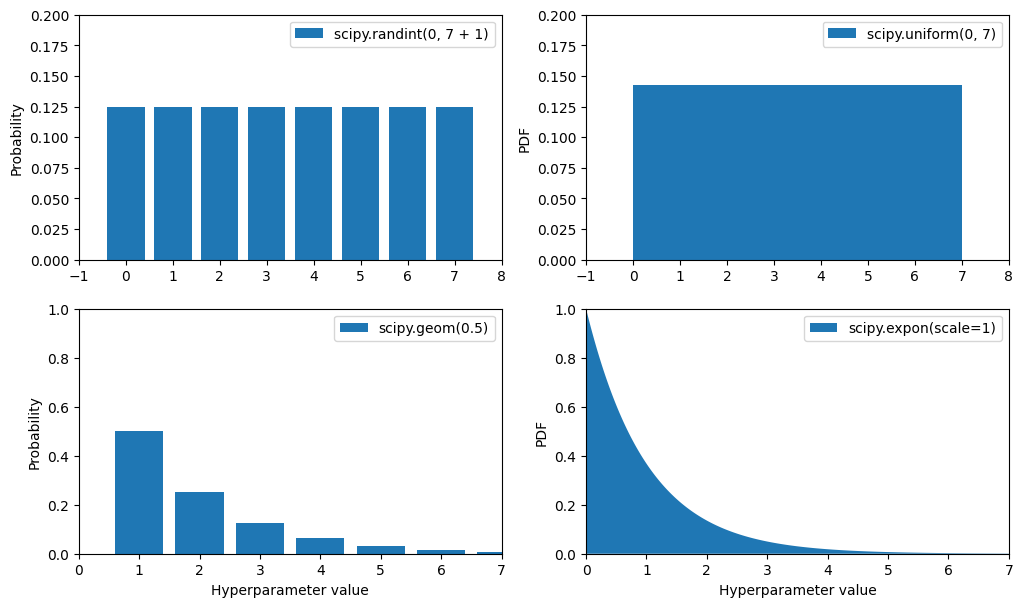

In [193]:
# plots a few distributions you can use in randomized search

from scipy.stats import randint, uniform, geom, expon

xs1 = np.arange(0, 7 + 1)
randint_distrib = randint(0, 7 + 1).pmf(xs1)

xs2 = np.linspace(0, 7, 500)
uniform_distrib = uniform(0, 7).pdf(xs2)

xs3 = np.arange(0, 7 + 1)
geom_distrib = geom(0.5).pmf(xs3)

xs4 = np.linspace(0, 7, 500)
expon_distrib = expon(scale=1).pdf(xs4)

plt.figure(figsize=(12, 7))

plt.subplot(2, 2, 1)
plt.bar(xs1, randint_distrib, label="scipy.randint(0, 7 + 1)")
plt.ylabel("Probability")
plt.legend()
plt.axis([-1, 8, 0, 0.2])

plt.subplot(2, 2, 2)
plt.fill_between(xs2, uniform_distrib, label="scipy.uniform(0, 7)")
plt.ylabel("PDF")
plt.legend()
plt.axis([-1, 8, 0, 0.2])

plt.subplot(2, 2, 3)
plt.bar(xs3, geom_distrib, label="scipy.geom(0.5)")
plt.xlabel("Hyperparameter value")
plt.ylabel("Probability")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.subplot(2, 2, 4)
plt.fill_between(xs4, expon_distrib, label="scipy.expon(scale=1)")
plt.xlabel("Hyperparameter value")
plt.ylabel("PDF")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.show()

Here are the PDF for `expon()` and `loguniform()` (left column), as well as the PDF of `log(X)` (right column). The right column shows the distribution of hyperparameter scales. You can see that `expon()` favors hyperparameters with roughly the desired scale, with a longer tail towards the smaller scales. But `loguniform()` does not favor any scale, they are all equally likely:

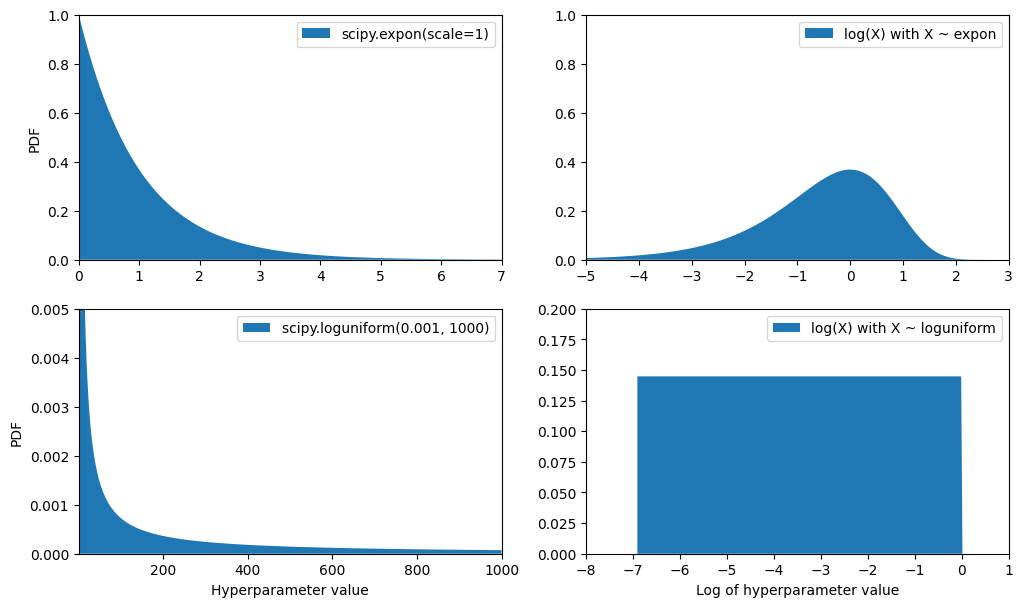

In [194]:
# shows the difference between expon and loguniform

from scipy.stats import loguniform

xs1 = np.linspace(0, 7, 500)
expon_distrib = expon(scale=1).pdf(xs1)

log_xs2 = np.linspace(-5, 3, 500)
log_expon_distrib = np.exp(log_xs2 - np.exp(log_xs2))

xs3 = np.linspace(0.001, 1000, 500)
loguniform_distrib = loguniform(0.001, 1000).pdf(xs3)

log_xs4 = np.linspace(np.log(0.001), np.log(1000), 500)
log_loguniform_distrib = uniform(np.log(0.001), np.log(1000)).pdf(log_xs4)

plt.figure(figsize=(12, 7))

plt.subplot(2, 2, 1)
plt.fill_between(xs1, expon_distrib,
                 label="scipy.expon(scale=1)")
plt.ylabel("PDF")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.subplot(2, 2, 2)
plt.fill_between(log_xs2, log_expon_distrib,
                 label="log(X) with X ~ expon")
plt.legend()
plt.axis([-5, 3, 0, 1])

plt.subplot(2, 2, 3)
plt.fill_between(xs3, loguniform_distrib,
                 label="scipy.loguniform(0.001, 1000)")
plt.xlabel("Hyperparameter value")
plt.ylabel("PDF")
plt.legend()
plt.axis([0.001, 1000, 0, 0.005])

plt.subplot(2, 2, 4)
plt.fill_between(log_xs4, log_loguniform_distrib,
                 label="log(X) with X ~ loguniform")
plt.xlabel("Log of hyperparameter value")
plt.legend()
plt.axis([-8, 1, 0, 0.2])

plt.show()

## Analyzing the Best Models and Their Errors
You will often gain good insights on the problem by inspecting the best models. For example, the RandomForestRegressor can indicate the relative importance of each attribute for making accurate predictions:

In [195]:
final_model = rnd_search.best_estimator_ # includes preprocessing
feature_importance = final_model["random_forest"].feature_importances_
feature_importance.round(2)

array([0.06, 0.05, 0.05, 0.01, 0.01, 0.01, 0.01, 0.19, 0.01, 0.01, 0.02,
       0.04, 0.01, 0.  , 0.02, 0.01, 0.01, 0.  , 0.02, 0.01, 0.  , 0.01,
       0.01, 0.01, 0.01, 0.02, 0.02, 0.01, 0.01, 0.01, 0.02, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.  , 0.01, 0.01, 0.01, 0.01, 0.01, 0.02,
       0.01, 0.01, 0.01, 0.01, 0.02, 0.02, 0.01, 0.01, 0.01, 0.  , 0.08,
       0.  , 0.  , 0.  , 0.01])

Let's sort these importance scores in descending order and display them next to their corresponding attribute names:

In [196]:
sorted(zip(feature_importance, final_model['preprocessing'].get_feature_names_out()), reverse=True)

[(np.float64(0.18883049114642353), 'log__median_income'),
 (np.float64(0.07550690165952419), 'cat__ocean_proximity_INLAND'),
 (np.float64(0.06427087748676082), 'bedrooms__ratio'),
 (np.float64(0.0521695509969851), 'rooms_per_house__ratio'),
 (np.float64(0.04664258696240615), 'people_per_house__ratio'),
 (np.float64(0.04244311259449021), 'geo__Cluster 3 similarity'),
 (np.float64(0.02329106317954673), 'geo__Cluster 17 similarity'),
 (np.float64(0.022649484211911694), 'geo__Cluster 18 similarity'),
 (np.float64(0.02197243576680579), 'geo__Cluster 22 similarity'),
 (np.float64(0.01881537204558837), 'geo__Cluster 40 similarity'),
 (np.float64(0.017669986767360032), 'geo__Cluster 10 similarity'),
 (np.float64(0.01754694953848625), 'geo__Cluster 35 similarity'),
 (np.float64(0.017274903717750808), 'geo__Cluster 41 similarity'),
 (np.float64(0.0160556631074201), 'geo__Cluster 6 similarity'),
 (np.float64(0.015811758952117744), 'geo__Cluster 2 similarity'),
 (np.float64(0.01477755940463033), '

With this information, you may want to try dropping some of the less useful features (e.g., apparently only one ocean_proximity category is really useful, so you could try dropping the others)
> The sklearn.feature_selection.SelectFromModel transformer can automatically drop the least useful features for us: ....

We should also look at the specific errors that our system makes, then try to understand why it makes them and what could fix the problem: adding extra features or getting rid of uninformative ones, cleaning up outliers, etc.
> Now is also a good time to ensure that our model not only works well on average, but also on all categories of districts, whether they're rural or urban, rich or poor, northern or southern, minority or not, etc. Creating subsets of our validation set for each category takes a bit of work, but it's important: if our model performs poorly on a whole category of districts, then it should probably not be deployed until the issue is solved, or at least it should not be used to make predictions for that category, as it may do more harm than good.

## Evaluating Our System on the Test Set

After tweaking our models for a while, we eventually have a system that performs sufficiently well. We are ready to evaluate the final model on the test set. There is nothing special about this process; just get the predictors and the labels from your test set and run our final_model to transform the data and make predictions, then evaluate these predictions:

In [197]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = root_mean_squared_error(y_test, final_predictions)
print(final_rmse)

41556.053474456494


We can compute a 95% confidence interval for the test RMSE:

In [198]:
from scipy import stats

def rmse(squared_errors):
    return np.sqrt(np.mean(squared_errors))

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
boot_result = stats.bootstrap([squared_errors], rmse, confidence_level=confidence, random_state=42)
rmse_lower, rmse_upper = boot_result.confidence_interval

rmse_lower, rmse_upper

(np.float64(39629.60159569332), np.float64(43816.66777858479))

If we did a lot of hyperparameter tuning, the performance will usually be slightly worse than what we measured using cross-validation. That's because our system ends up fine-tuned to perform well on the validation data and will likely not perform as well on unknown datasets. That's not the case in this example since the test RMSE is lower than the validation RMSE, but when it happens we must resist the temptation to tweak the hyperparameters to make the numbers look good on the test set; the improvements would be unlikely to generalize to new data.

Now comes the project prelaunch phase: we need to present our solution (highlighting what we have learned, what worked and what did not, what assumptions were made, and what our system's limitations are), documenting everything, and create nice presentations with clear visualizations and easy-to-remember statements.

## Launch, Monitor, and Maintain the System
Now we need to get our solution ready for production (e.g., polish the code, write documentation and tests, and so on). Then we can deploy our model to our production environment.
#
The most basic way to do this is to just save the best model we trained, transfer the file to our production environment, and load it.

In [199]:
# to save the model - use joblib library
import joblib

joblib.dump(final_model, "my_california_housing_model.pkl")

# it's often a good idea to save every model we experiment with so that we can come back easily to any model we want.
# we may also save the cross-validation scores and perhaps the actual predictions on the validation set.
# this will allow us to easily compare scores across model types, and compare the types of errors they make.

['my_california_housing_model.pkl']

In [200]:
# once our model is transferred to production, we can load it and use it.
# for this we must first import any custom classes and functions the model relies on, 

# extra code – excluded for conciseness
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel

def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

#class ClusterSimilarity(BaseEstimator, TransformerMixin):
#    [...]

final_model_reloaded = joblib.load("my_california_housing_model.pkl")

new_data = housing.iloc[:5]  # pretend these are new districts
predictions = final_model_reloaded.predict(new_data)

In [201]:
predictions

array([442520.14, 452569.09, 105878.  ,  99171.  , 330284.02])